In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import vgg19

In [10]:
image_size = 512
channels = 3

In [37]:
def load_image(path):
  image = Image.open(path)
  image = image.resize((image_size,image_size))
  image = np.array(image)
  return image

content_image = load_image('/content/GoldenGate.jpg')
style_image = load_image('/content/starry_night.jpg')

(-0.5, 511.5, 511.5, -0.5)

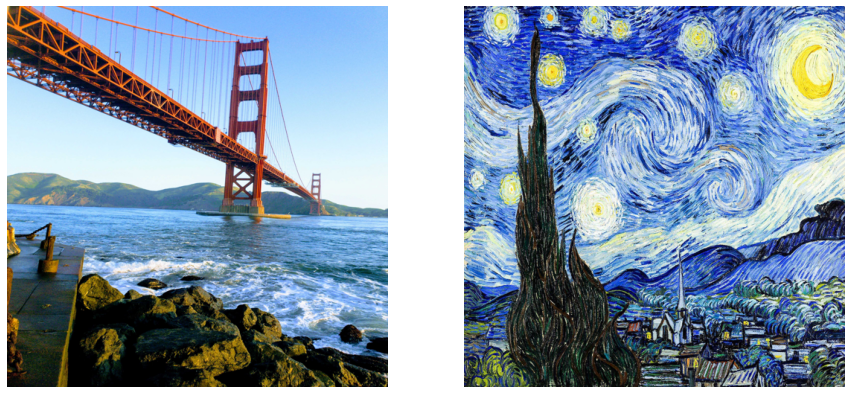

In [38]:
plt.figure(figsize = (15,15))

plt.subplot(1,2,1)
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_image)
plt.axis('off')

In [39]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [40]:
def build_model():
  model = vgg19.VGG19(include_top = False, weights = 'imagenet')
  model.trainable = True

  output_layers = [model.get_layer(layer).output for layer in (content_layers + style_layers)]
  return tf.keras.Model(model.input, output_layers)

base_model = build_model

In [41]:
def preprocess_image(image):
    return vgg19.preprocess_input(np.expand_dims(image, axis=0))

In [42]:
VGG_BIAS = vgg19.preprocess_input((np.zeros(3)).astype('float32'))
def deprocess_image(image):
    image = image - VGG_BIAS

    
    image = np.concatenate([np.array(image)[:,:,:,2].reshape(image_size, image_size, 1), 
                            np.array(image)[:,:,:,1].reshape(image_size, image_size, 1), 
                            np.array(image)[:,:,:,0].reshape(image_size, image_size, 1)], axis=2)
    return image

In [43]:
def get_content_loss(gen_img, base_content_image):
    return tf.reduce_mean(tf.square(base_content_image - gen_img))

In [44]:
def get_gram_matrix(layer):
    layer = tf.reshape(layer, (-1, layer.shape[-1]))
    gram_matrix = tf.matmul(layer, layer, transpose_a=True)
    n = gram_matrix.shape[0]
    return gram_matrix/tf.cast(n, tf.float32), n

def get_style_loss(gen_img, base_style_img):
    gram_gen_img, n1 = get_gram_matrix(gen_img)
    gram_base_style_img, n2 = get_gram_matrix(base_style_img)
    
    assert n1 == n2
    
    loss = tf.reduce_mean(tf.square(gram_gen_img - gram_base_style_img))/(4*(n1**2)*(n2**2))
    return loss
    

In [45]:
def get_total_loss(gen_img, base_content_image, base_style_img, alpha = 0.5):
    
    # content loss
    new_gen_img_cont = gen_img[:len(content_layers)]
    new_base_content_image = base_content_image[:len(content_layers)]
    content_loss = 0
    N1 = len(new_gen_img_cont)
    
    for i in range(N1):
        content_loss += get_content_loss(new_gen_img_cont[i], new_base_content_image[i])/N1
        
    # style loss
    new_gen_img_sty = gen_img[len(content_layers):]
    new_base_style_img = base_style_img[len(content_layers):]
    style_loss = 0
    N2 = len(new_gen_img_sty)
    
    for i in range(N2):
        style_loss += get_style_loss(new_gen_img_sty[i], new_base_style_img[i])
        
    total_loss = ((1 - alpha) * style_loss) + (alpha * content_loss)
    return total_loss

In [46]:
processed_content_image = preprocess_image(content_image)
processed_style_image = preprocess_image(style_image)

processed_input_image = processed_content_image + tf.random.normal(processed_content_image.shape)

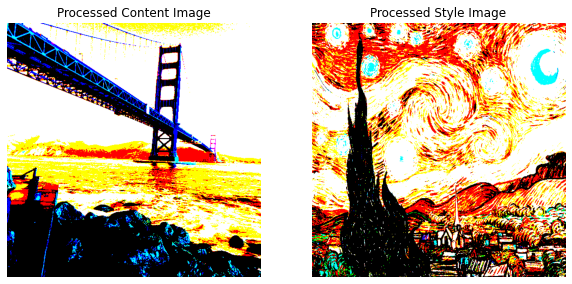

In [47]:
plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.imshow(np.clip(processed_content_image[0], 0, 1))
plt.title('Processed Content Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.clip(processed_style_image[0], 0, 1))
plt.title('Processed Style Image')
plt.axis('off')

plt.show()

In [48]:
deprocessed_content_image = deprocess_image(processed_content_image)
deprocessed_style_image = deprocess_image(processed_style_image)

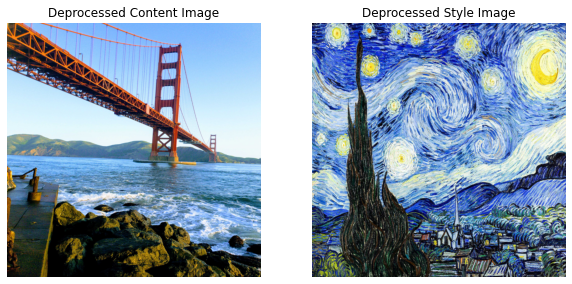

In [49]:
plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.imshow(deprocessed_content_image.astype('uint8'))
plt.title('Deprocessed Content Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(deprocessed_style_image.astype('uint8'))
plt.title('Deprocessed Style Image')
plt.axis('off')

plt.show()

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1 = 0.99, epsilon=1e-3)

In [51]:
def edit_image(epochs = 10):
    
    min_val = VGG_BIAS
    max_val = 255 + VGG_BIAS
    
    base_model = build_model()
    
    processed_content_image = preprocess_image(content_image)
    processed_style_image = preprocess_image(style_image)
    processed_input_image = tf.Variable(processed_content_image + tf.random.normal(processed_content_image.shape))
    
    base_content_image = base_model(processed_content_image)
    base_style_image = base_model(processed_style_image)

    for e in range(epochs):
        with tf.GradientTape() as tape:
            base_processed_content_input = base_model(processed_input_image)
            loss = get_total_loss(base_processed_content_input, base_content_image, base_style_image)

        grad = tape.gradient(loss, processed_input_image)
        opt.apply_gradients([(grad, processed_input_image)])

        clipped = tf.clip_by_value(processed_input_image, min_val, max_val)
        processed_input_image.assign(clipped)


        if e%100 == 0:
            print(f'Epoch: {e} \t Loss: {loss}')
            
    return processed_input_image

In [52]:
EPOCHS = 300
processed_input_image = edit_image(EPOCHS)

Epoch: 0 	 Loss: 305109.78125
Epoch: 100 	 Loss: 18242.720703125
Epoch: 200 	 Loss: 3589.99609375


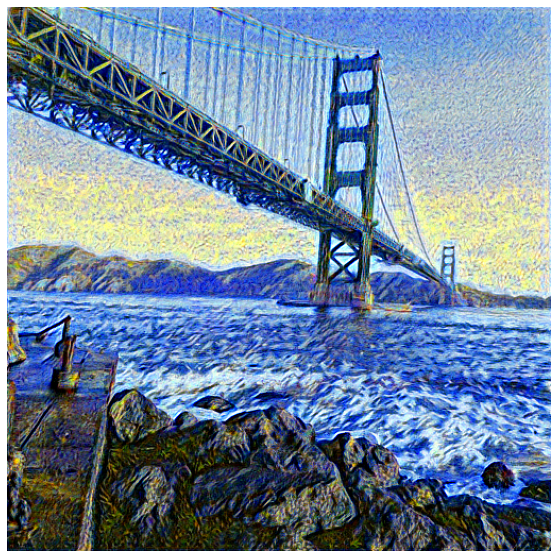

In [53]:
plt.figure(figsize = (10 ,10))
plt.imshow(deprocess_image(processed_input_image).astype('uint8'))
plt.axis('off');